# Intro to Pytorch - MNIST Digit Classification

In this notebook, we cover the basics of PyTorch and will train our first (shallow) neural network from scratch on the MNIST digit classification dataset.

Let's start by importing the libraries that we will need and setting up jupyter. You can add additional imports later and re-run the cell to make those imports available throughout the notebook.

In [0]:
%matplotlib inline

# import numpy - array processing library
import numpy as np 

# pytorch imports:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# pytorch functionality for image datasets
from torchvision import datasets, transforms

# standard plotting library
import matplotlib.pyplot as plt

We supply you with a function to plot multiple images along with their labels. Please ignore for now:

In [0]:
def show_image_grid(X, y=None, y_pred=None, title=None, nrow=6, ncol=4, **kwargs):
    max_num = nrow*ncol
    X = X[:max_num]
    if len(X) < max_num:
        ncol = len(X) // nrow + 1
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    if X.dim() != 4:
        X = X[:, None]

    plt.figure(title, figsize=(2*nrow, 2*ncol + (0 if y is None else 1)))
    if title:
        plt.title(title)
        
    if isinstance(y, torch.Tensor):
        y = y.numpy()
        
    for i, Xi in enumerate(X):
        plt.subplot(ncol, nrow, i+1)
        img = Xi.numpy().transpose((1, 2, 0))
        if img.shape[2] == 1:
            img = img[..., 0]
        plt.imshow(img)

        title = ""
        if y is not None:
          title += str(int(y[i]))
        if y_pred is not None:
          title += "/" + str(int(y_pred[i]))
        if len(title) > 0: 
          plt.title(title)

        plt.axis('off')
    
    plt.axis('off')


## Some PyTorch basics

Creating tensors:

In [3]:
V = torch.tensor([20., 23., 31.])
V

tensor([20., 23., 31.])

Indexing into tensors gives you the elements of your tensor

In [4]:
V[0]

tensor(20.)

In [5]:
V[1]

tensor(23.)

In [0]:
#V[3]

In [7]:
V[0].item()

20.0

Tensors can be multi-dimensional, e.g. matrices:

In [8]:
M = torch.tensor([[1., 2., 3.], [4., 5., 6]])
M

tensor([[1., 2., 3.],
        [4., 5., 6.]])

When we index a matrix, we get one row as a vector.

In [9]:
M[0]

tensor([1., 2., 3.])

In [10]:
M[0, 1]

tensor(2.)

We can get one column from that matrix by using the fancy `:` notation in indexing, meaning that we want to take all the elements from that *axis*.


In [11]:
M[:, 1]

tensor([2., 5.])

In [12]:
M[:, 1:3]

tensor([[2., 3.],
        [5., 6.]])

Tensors can have higher number of dimensions, for example rank-3 tensors are basically arrays of matrices:

In [13]:
# Create a rank 3 tensor of size 2x2x2.
T = torch.tensor([[[1., 2.], [3., 4.]],
          [[5., 6.], [7., 8.]]])
T

tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])

In [14]:
# create a tensor with random numbers
torch.randn((3, 2, 5, 2))

tensor([[[[ 0.0096,  2.3117],
          [ 0.0327,  0.0786],
          [-1.6615,  0.4794],
          [ 0.0386, -0.4484],
          [ 1.3243,  0.4530]],

         [[ 0.3998,  0.4145],
          [-0.6653,  0.1154],
          [-0.6380, -0.1220],
          [ 1.1558, -1.5852],
          [-1.1618,  1.3816]]],


        [[[ 0.0206,  1.2044],
          [ 0.3365, -0.1158],
          [-0.1294,  0.1853],
          [ 0.4856,  0.3756],
          [ 0.1587, -0.5727]],

         [[ 0.3716, -2.2060],
          [ 2.5548, -1.1536],
          [ 1.7288,  0.5706],
          [ 1.1317, -0.0217],
          [ 1.6639, -3.0039]]],


        [[[ 0.8538,  1.6227],
          [ 0.9212,  1.4087],
          [ 1.0256, -1.8749],
          [ 1.7047, -1.0722],
          [-2.1677,  0.2694]],

         [[ 0.2085, -1.3243],
          [ 1.6082, -0.7456],
          [-0.5584, -0.6456],
          [-0.4353,  0.9352],
          [-1.2321, -1.0523]]]])

Typical mathematical operators are overloaded for tensors, so you can add all entries of one matrix to another matrix with a simple line. No need to write for loops :)

In [15]:
A = torch.randn((3, 2))
A

tensor([[-0.3808,  0.9405],
        [-0.3037,  0.1348],
        [-0.9899,  0.2959]])

In [16]:
B = torch.randn((3, 2))
B

tensor([[ 1.5140, -0.3649],
        [ 1.5284, -0.6043],
        [ 1.2420, -0.7322]])

In [17]:
A + B

tensor([[ 1.1332,  0.5756],
        [ 1.2248, -0.4696],
        [ 0.2521, -0.4363]])

In [18]:
A * B

tensor([[-0.5765, -0.3432],
        [-0.4641, -0.0815],
        [-1.2295, -0.2167]])

In [19]:
2 * A

tensor([[-0.7615,  1.8811],
        [-0.6073,  0.2696],
        [-1.9799,  0.5918]])

In [20]:
torch.log(A)

tensor([[    nan, -0.0613],
        [    nan, -2.0041],
        [    nan, -1.2178]])



## Let's get started: loading the data

First, lets load the dataset:

In [21]:
train_data = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=transforms.ToTensor())
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In order to sample from this dataset, we need a DataLoader. A DataLoader samples mini batches from a DataSet and can also be used to apply transformations to the data (here, we just want to transform the data to a pytorch tensor).

In [22]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
train_loader

MNIST also provides a validation set that we can use to test how well our model performs.

In [0]:
valid_data = datasets.MNIST(root='./data', train=False, 
                            download=True, transform=transforms.ToTensor())
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)

Lets sample one batch of data from the dataset:

In [0]:
#for Xb, yb in train_loader:
#  print(Xb)
#  break

Xb, yb = next(iter(train_loader))

In [25]:
Xb.shape

torch.Size([128, 1, 28, 28])

In [26]:
Xb[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

We can use matplotlib or the show_image_grid function to visualize the data.

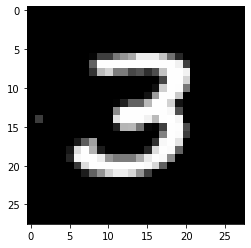

In [27]:
plt.gray() # sets matplotlib colormap
plt.imshow(Xb[0,0])

In [28]:
yb

tensor([3, 0, 2, 2, 3, 1, 7, 7, 5, 4, 1, 0, 4, 4, 8, 1, 5, 2, 4, 2, 3, 2, 5, 9,
        9, 2, 1, 7, 4, 9, 9, 9, 1, 9, 9, 8, 3, 3, 0, 9, 9, 3, 0, 7, 3, 0, 1, 4,
        5, 5, 1, 8, 6, 8, 3, 1, 2, 6, 2, 4, 9, 8, 1, 3, 2, 9, 3, 2, 2, 0, 0, 8,
        7, 9, 9, 5, 1, 3, 9, 5, 3, 2, 1, 6, 7, 1, 6, 3, 8, 4, 3, 7, 0, 3, 3, 6,
        1, 1, 0, 7, 1, 8, 4, 3, 6, 9, 9, 6, 0, 8, 5, 3, 1, 3, 8, 9, 4, 9, 5, 7,
        3, 7, 7, 7, 1, 8, 9, 6])

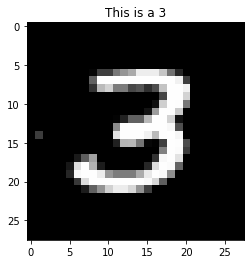

In [29]:
plt.imshow(Xb[0, 0])
plt.title(f"This is a {yb[0]}")
plt.show()

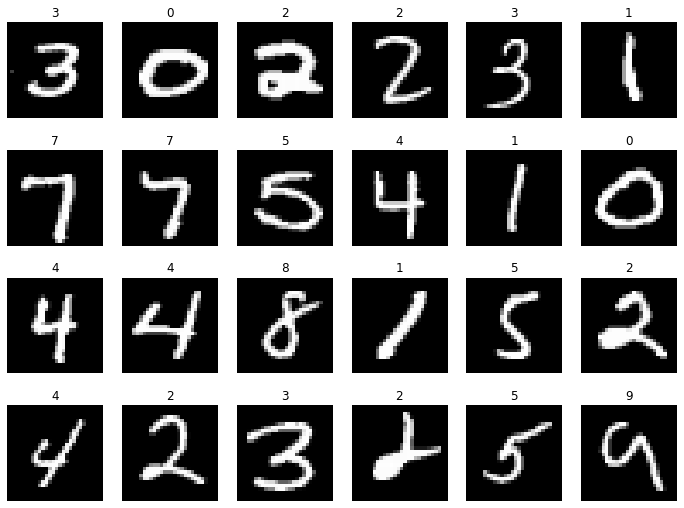

In [30]:
show_image_grid(Xb, yb)

## Setup the model

We want to train a linear model from a vectorized (flattened) version of the image. We first reshape our image tensor

In [31]:
Xb_flat = Xb.view(Xb.shape[0], -1)
Xb_flat.shape

torch.Size([128, 784])

We now initialize the weights and biases (parameters) of our network. We use a weight matrix to densely connect the 28x28 dimensional input to an output layer of size 10 and add a bias term. This simplistic shallow linear "neural network" outputs 10 class scores for each of the digit between 0-9.

In [32]:
weight = torch.randn((28*28, 10))
bias = torch.zeros(10)

output = Xb_flat @ weight  + bias
output.shape

torch.Size([128, 10])

In [33]:
output[0]

tensor([  6.2953,  13.3739,  -5.8948,   0.2962,   2.2030, -10.7455,   1.7545,
          4.1362,  -7.7766,  10.3857])

Lets refactor our neural network forward pass and wrap it into a function that we can easily call later on

In [34]:
def forward(X, weight, bias):
    return X.view(-1, 28*28) @ weight + bias

forward(Xb, weight, bias)[0]

tensor([  6.2953,  13.3739,  -5.8948,   0.2962,   2.2030, -10.7455,   1.7545,
          4.1362,  -7.7766,  10.3857])

## Metrics

We will also need a way of measuring how good our model is. Here, we will use the classification accuracy by comparing the label predicted by the network (simply the neuron with the largest score of our output layer) with the actual labels and counting how often those agree.

In [35]:
print("predicted label:", output.argmax(1))
print("   actual label:", yb)

yb == output.argmax(1)

predicted label: tensor([1, 1, 5, 7, 7, 7, 7, 4, 1, 0, 4, 1, 9, 1, 4, 6, 7, 5, 5, 1, 8, 9, 9, 9,
        9, 9, 9, 9, 4, 9, 9, 9, 4, 9, 9, 9, 7, 1, 1, 9, 9, 1, 5, 0, 1, 1, 4, 9,
        5, 5, 9, 5, 9, 5, 1, 6, 9, 9, 0, 9, 5, 9, 6, 0, 1, 5, 0, 1, 9, 1, 5, 5,
        6, 5, 5, 9, 7, 3, 9, 9, 1, 5, 6, 9, 7, 9, 9, 7, 9, 9, 9, 9, 1, 7, 7, 0,
        6, 2, 9, 7, 4, 5, 1, 9, 7, 7, 9, 0, 0, 1, 9, 7, 6, 9, 7, 9, 9, 9, 0, 3,
        0, 1, 9, 7, 7, 6, 9, 9])
   actual label: tensor([3, 0, 2, 2, 3, 1, 7, 7, 5, 4, 1, 0, 4, 4, 8, 1, 5, 2, 4, 2, 3, 2, 5, 9,
        9, 2, 1, 7, 4, 9, 9, 9, 1, 9, 9, 8, 3, 3, 0, 9, 9, 3, 0, 7, 3, 0, 1, 4,
        5, 5, 1, 8, 6, 8, 3, 1, 2, 6, 2, 4, 9, 8, 1, 3, 2, 9, 3, 2, 2, 0, 0, 8,
        7, 9, 9, 5, 1, 3, 9, 5, 3, 2, 1, 6, 7, 1, 6, 3, 8, 4, 3, 7, 0, 3, 3, 6,
        1, 1, 0, 7, 1, 8, 4, 3, 6, 9, 9, 6, 0, 8, 5, 3, 1, 3, 8, 9, 4, 9, 5, 7,
        3, 7, 7, 7, 1, 8, 9, 6])


tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False,  True,  True,
         True,  True, False,  True,  True, False, False, False, False,  True,
         True, False, False, False, False, False, False, False,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False,  True, False,  True, False,
        False, False, False, False, False,  True, False,  True, False, False,
        False, False, False,  True, False, False,  True, False])

We can compute an accuracy between 0 and 1 simply by averaging the above binary vector. 

In [36]:
def accuracy(output, label):
    return (output.argmax(1) == label).float().mean()

accuracy(output, yb)

tensor(0.1797)

## Loss

To measure how well our network does, we cannot directly use our accuracy metric - Do you know why?

Instead, we will apply a softmax to the 10-dimensional output, which gives us a probability between 0 and 1 for each of the 10 classes.

In [37]:
F.softmax(output, dim=1)

tensor([[8.0182e-04, 9.5116e-01, 4.0734e-09,  ..., 9.2549e-05, 6.2048e-10,
         4.7918e-02],
        [4.4604e-09, 9.9851e-01, 1.4547e-13,  ..., 9.5607e-10, 2.3903e-22,
         1.7672e-06],
        [9.8299e-06, 1.5182e-02, 1.6234e-07,  ..., 1.1379e-08, 8.4882e-07,
         2.3726e-03],
        ...,
        [3.6699e-10, 1.5819e-02, 7.6910e-09,  ..., 9.5150e-08, 3.1718e-08,
         3.1134e-02],
        [3.9231e-07, 3.7810e-04, 2.3921e-07,  ..., 3.2032e-01, 1.5332e-06,
         6.7493e-01],
        [5.4402e-10, 1.2656e-04, 2.7774e-17,  ..., 7.9478e-04, 2.8945e-23,
         9.9906e-01]])

In [38]:
F.softmax(output, dim=1)[0]

tensor([8.0182e-04, 9.5116e-01, 4.0734e-09, 1.9893e-06, 1.3391e-05, 3.1868e-11,
        8.5513e-06, 9.2549e-05, 6.2048e-10, 4.7918e-02])

In [39]:
F.softmax(output, dim=1).sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

However, instead of computing the negative log-likelihood now from the softmax output, it is both quicker and numerically more stable to directly use the cross_entropy loss from PyTorch. Notice that you need to pass the output of your last layer directly to cross_entropy - **NEVER pass softmaxed output directly, use the explicit softmax presented above only if you want to output class probabilities at test time.** 

In [40]:
loss = F.cross_entropy(output, yb)
loss

tensor(12.5662)

You can learn more about this function here: https://pytorch.org/docs/master/nn.html#crossentropyloss

There, it says that it just combines LogSoftmax and NLLLoss, whose functional variants are:

In [41]:
F.nll_loss(F.log_softmax(output, dim=1), yb)

tensor(12.5662)

Indeed, this gives us the same result, and we can further split this to see that it just applies log to the softmax result:

In [42]:
F.nll_loss(torch.log(F.softmax(output, dim=1)), yb)

tensor(12.5662)

In fact, even unpacking that call results in relatively compact code. We can see that the negative log likelihood loss simply averages the log-probabilities for the correct classes stored in `yb`. This makes sense, we want the probabilities of the correct classes to be as high as possible. In other words we want to maximize that average *or* minimize negated value of that average (we negate it because we always want to *minimize* a loss, since a loss should measure the *lousiness* of our network).

In [43]:
probs = F.softmax(output, dim=1)
log_probs = torch.log(probs)
# here comes F.nll_loss:
correct_class_log_probs = log_probs[torch.arange(batch_size), yb]
-torch.sum(correct_class_log_probs) / batch_size

tensor(12.5662)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


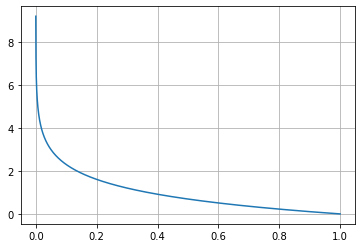

In [44]:
prob = np.linspace(0.0, 1, 10000)
plt.plot(prob, -np.log(prob))
plt.grid()

### Further Info about loss functions

Note that what we're using here is commonly called the (softmax-) cross-entropy, sometimes also abbreviated log-loss. 

If you want to learn more about different loss functions, this is a nice overview: https://arxiv.org/abs/1702.05659

In general, for multi-class classification problems the cross-entropy loss works very well. What is important from time-to-time is to use the `weight` parameter of the `CrossEntropyLoss` class (or `F.cross_entropy function`) to perform class-weighting in imbalanced datasets that "happen" frequently in practice, see e.g. in this paper:
http://openaccess.thecvf.com/content_CVPR_2019/html/Cui_Class-Balanced_Loss_Based_on_Effective_Number_of_Samples_CVPR_2019_paper.html


## Backpropagation

We now need to compute the gradient of the weight and bias tensor with respect to the loss. Luckily, PyTorch supplies us with an autograd mechanism that internally computes the gradients at each operations and propagates the error from the output of the network to the input, often called the backward pass.

Remember, that is what we did until now:

In [45]:
# initialize network parameters
weight = torch.randn((28*28, 10), requires_grad=True)
bias = torch.zeros(10, requires_grad=True)
# run one batch of images (Xb) through the network
output = forward(Xb, weight, bias)
# compute loss
loss = F.cross_entropy(output, yb)
loss

tensor(12.9651, grad_fn=<NllLossBackward>)

Now we want to know how we should change the bias and weight parameter in order to *decrease* the loss. For this, we're using the *gradient* of the parameters (with respect to the *loss*).

The gradients of a tensor can be accessed by the .grad attribute after running backward on the output as follows. At first, the gradient is empty:

In [0]:
bias.grad

We then run backpropagation by calling:

In [0]:
loss.backward()

Then, we can read out the gradient using `bias.grad`, which returns a tensor that has the derivative of all the values in the `bias` parameter with respect to the loss.

### Question

What is the shape of the gradient of `bias` and `weight`?

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

In [48]:
bias.grad

tensor([ 0.0330, -0.1252,  0.0091, -0.1540,  0.0782, -0.0180,  0.2962, -0.0592,
         0.0536, -0.1136])

In [49]:
bias.grad.shape

torch.Size([10])

In [50]:
weight.grad.shape

torch.Size([784, 10])

In [51]:
weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

You can learn more about backpropagation and the math basics here:
 - study [Micrograd](https://github.com/karpathy/micrograd) - a tine autograd engine written in Python, only about 100 lines of code
 - a very [gentle writeup](https://explained.ai/matrix-calculus/) of the mathematical background of matrix and derivative calculus needed by deep learning
 - read [the autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) from the PyTorch authors



## Gradient descent

We can now change the weight and bias parameter in order to bring down the loss. Since we don't want to backpropagate through this gradient update step, we need to disable the autograd feature for these steps using with no_grad. We also need to define a learning rate (lr).

In [52]:
lr = 1.e-1

print("bias before: ", bias)

with torch.no_grad(): # TODO: why do we need this?
    weight -= lr * weight.grad
    weight.grad.zero_()
    bias -= lr * bias.grad
    bias.grad.zero_()
    
print("bias after: ", bias)

bias before:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
bias after:  tensor([-0.0033,  0.0125, -0.0009,  0.0154, -0.0078,  0.0018, -0.0296,  0.0059,
        -0.0054,  0.0114], requires_grad=True)


Did our model already improve after this one small mini batch gradient update?

In [53]:
output = forward(Xb, weight, bias)
F.cross_entropy(output, yb)

tensor(12.2662, grad_fn=<NllLossBackward>)

In [54]:
accuracy(output, yb)

tensor(0.0547)

# Full Training Loop

In practice, we want to do these gradient update steps multiple times over the whole dataset. Usually, we construct an inner loop that runs over the whole (shuffled!) training set, and an outer loop that repeats this for a set number of epochs.

Also, we were not very smart in initializing our weights. Lets use the popular [kaiming initialization](https://arxiv.org/abs/1502.01852) for initializing the weight matrix. Initialization is quite important, but as we will see later most of the times PyTorch provides us with a safe default. We just don't use it here since we did not yet learn about nn.Modules, yet.

We should also measure the accuracy on our validation set after each epoch.

## Your Tasks:

 - Finish the training loop prepared below and train the network for 5 epochs. What accuracy do you achieve?
 - Bonus: Visualize some images from the validation set that are misclassified - what can you see?
 - Bonus: Instead of MNIST, try FashionMNIST, which has the same format but is much harder then MNIST


In [55]:
def forward(X, weight, bias):
    return X.view(-1, 28*28) @ weight + bias

def accuracy(output, label):
    return (output.argmax(1) == label).float().mean()

lr = 0.1

# initialize weights
weight = torch.zeros((28*28, 10), requires_grad=True)
nn.init.kaiming_uniform_(weight, mode='fan_out')
bias = torch.zeros(10, requires_grad=True)

for epoch in range(5):
    # train on mini batches
    losses = []
    for X, y in train_loader:
        # TODO: forward pass
        # compute loss
        loss = # TODO
        losses.append(loss.item())
        # TODO: backward pass
        with torch.no_grad():
          # TODO: gradient descent update
          # TODO: set gradients to zero
            
    # measure accuracy on the validation set
    acc = np.mean([
        accuracy(forward(X, weight, bias), y)
        for X, y in valid_loader
    ])
    print("epoch % 5d: loss: % 8.5f accuracy: %4.2f" % (epoch, np.mean(losses), acc.item()))


SyntaxError: ignored

After training, you can visualize predictions of digits from the validation set to check if they are correct:

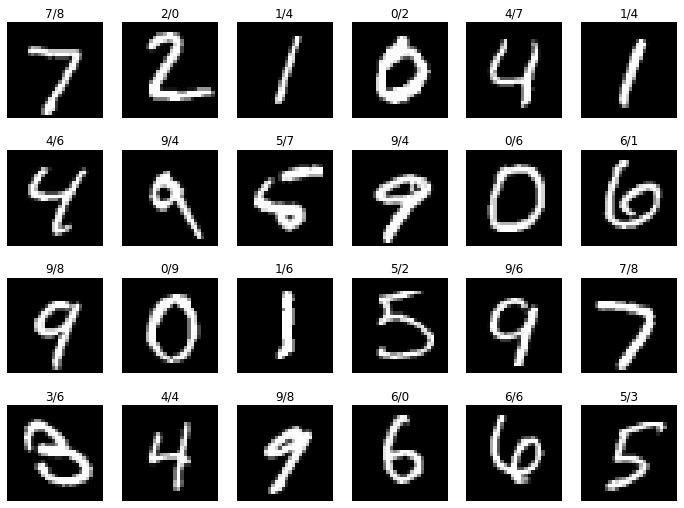

In [56]:
Xv, yv = next(iter(valid_loader))
show_image_grid(Xv, y=yv, y_pred=forward(Xv, weight, bias).argmax(dim=1))

## Lets take a look inside

Since our model is so simple, we can actually take a look at the learned parameters of the network, as the weight matrix is just a stack of vectorized 28x28 images itself. Basically, we have trained 10 linear digit detectors. Lets have a look:

In [57]:
W = weight.detach()
W.shape

torch.Size([784, 10])

In [58]:
W[:, 0]

tensor([-1.6036e+00, -1.9762e+00, -6.3696e-01,  4.3453e-01, -1.0491e-02,
         2.1147e-01, -2.1573e+00, -3.1303e-02, -1.9749e+00,  1.5862e+00,
        -6.7068e-01, -5.9453e-01,  1.9194e+00,  7.1770e-02, -6.2969e-01,
         1.7404e+00,  9.2038e-01, -6.4219e-01,  1.5082e-01,  4.7707e-01,
         1.1237e+00, -1.7000e+00, -5.1334e-01, -1.5530e+00, -1.5603e+00,
        -2.7485e-01,  2.8300e+00, -5.8184e-01,  1.0997e-01, -4.9472e-01,
         3.1259e-01, -9.4432e-01, -6.3156e-01, -5.3690e-01,  2.1352e+00,
         1.0691e+00, -3.7033e-01,  4.4422e-01, -3.0148e-01, -1.3141e+00,
         9.6737e-02,  1.3405e+00, -1.0902e+00, -2.7880e-01,  6.2050e-01,
        -6.8654e-02, -7.1206e-01, -5.3073e-02, -2.6449e-01,  1.4725e+00,
         8.1347e-01, -8.4567e-01,  3.5915e-01, -7.0761e-01, -4.1051e-01,
        -1.6953e+00, -1.1784e+00, -9.6894e-01,  4.2685e-01,  2.6500e-02,
        -1.1055e+00, -5.6181e-01,  3.0096e-01,  1.5990e+00, -4.9900e-01,
        -1.0607e+00, -4.9504e-01,  8.5180e-01, -7.7

Each row basically corresponds to a template of that class, which we can visualize.

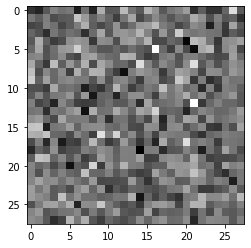

In [59]:
plt.imshow(W[:, 0].reshape(28, 28))

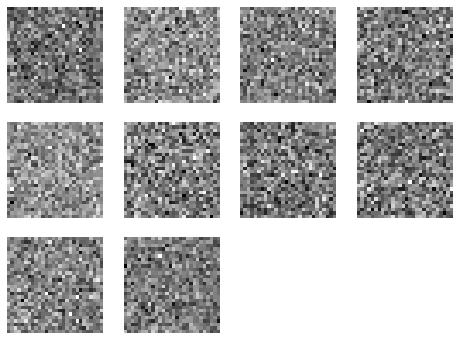

In [60]:
show_image_grid(W.reshape(28, 28, 10).permute(2, 0, 1), nrow=4)